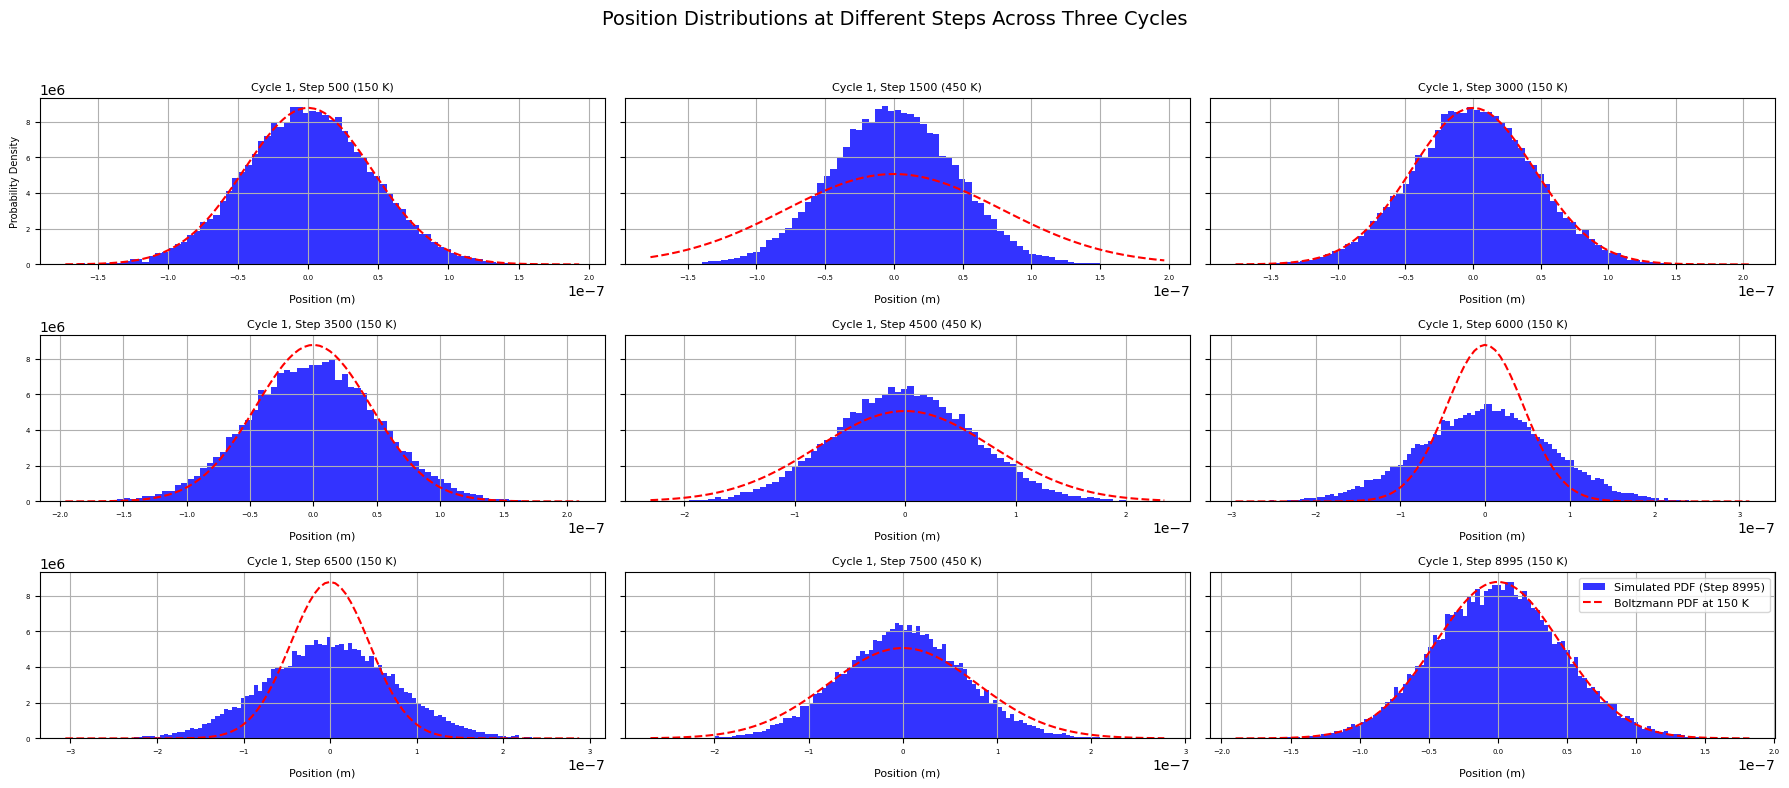

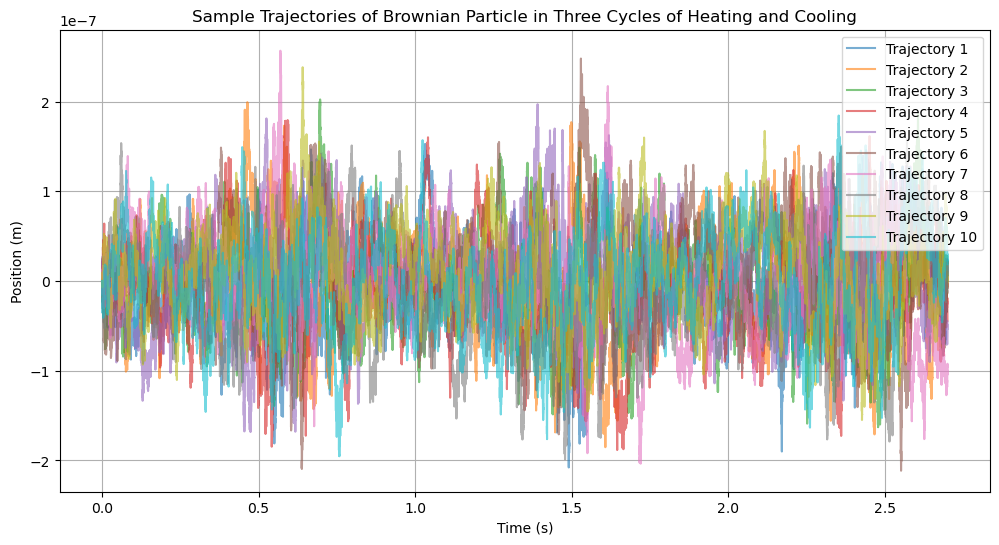

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define constants
k = 1e-6       # Spring constant (N/m)
k_B = 1.38e-23 # Boltzmann constant (J/K)
gamma = 2e-8   # Friction coefficient (Ns/m)
dt = 0.0001    # Time step (s)
pre_equilibration_steps = 3000  # Pre-equilibration steps at initial 150 K

# Temperatures
T_start = 150  # Starting temperature (K)
T_max = 450    # Maximum temperature (K)
T_end = 150    # End temperature after cooling (K)

# Simulation steps for each phase
n_steps_heating = 3000   # Number of steps for heating phase
n_steps_cooling = 3000   # Number of steps for cooling phase
n_steps_cycle = pre_equilibration_steps + n_steps_heating + n_steps_cooling
total_steps = n_steps_cycle * 3  # Total steps for three cycles

# Langevin simulation function
def langevin_simulation_multi_cycles(T_start, T_max, T_end, k, gamma, dt, n_steps_heating, n_steps_cooling, pre_equilibration_steps, initial_position):
    x = np.zeros(total_steps)
    x[0] = initial_position  # Start at rest

    # Define temperature sequence for each cycle
    temperatures = [T_start] * pre_equilibration_steps + \
                   np.linspace(T_start, T_max, n_steps_heating).tolist() + \
                   np.linspace(T_max, T_end, n_steps_cooling).tolist()

    for cycle in range(3):
        offset = cycle * n_steps_cycle
        for i in range(1, n_steps_cycle):
            T_current = temperatures[i]
            random_force = np.sqrt(2 * k_B * T_current * gamma / dt) * np.random.randn()
            x[offset + i] = x[offset + i - 1] - (k / gamma) * x[offset + i - 1] * dt + random_force * dt / gamma

    return x

# Boltzmann distribution function
def boltzmann_distribution(x, k, k_B, T):
    normalization_factor = np.sqrt(k / (2 * np.pi * k_B * T))
    exp_part = np.exp(-k * x**2 / (2 * k_B * T))
    return normalization_factor * exp_part

# Steps for histogram plotting, matching three cycles at equilibrium points
positions_at_steps = {
    500: [], 1500: [], 3000: [], 3500: [], 4500: [], 6000: [],
    6500: [], 7500: [], 8995: []
}
temperatures_at_steps = {
    500: T_start, 1500: T_max, 3000: T_end,  # End of Cycle 1
    3500: T_start, 4500: T_max, 6000: T_end,  # End of Cycle 2
    6500: T_start, 7500: T_max, 8995: T_end   # End of Cycle 3
}

# Simulate trajectories and store positions at specified steps
num_trajectories = 25000
all_trajectories = []  # Store entire trajectories for plotting

for _ in range(num_trajectories):
    initial_position = 0
    x_sim = langevin_simulation_multi_cycles(T_start, T_max, T_end, k, gamma, dt, n_steps_heating, n_steps_cooling, pre_equilibration_steps, initial_position)
    all_trajectories.append(x_sim)
    for step in positions_at_steps.keys():
        if step < total_steps:
            positions_at_steps[step].append(x_sim[step])

# Plot a histogram of the positions for each selected step with the Boltzmann distribution
fig, axs = plt.subplots(3, 3, figsize=(18, 8), sharey=True)
fig.suptitle('Position Distributions at Different Steps Across Three Cycles', fontsize=14)

for i, (step, positions) in enumerate(positions_at_steps.items()):
    T_current = temperatures_at_steps[step]
    ax = axs[i // 3, i % 3]
    bins_count = 80 if step % n_steps_cycle < pre_equilibration_steps + n_steps_heating else 120
    
    # Plot histogram of simulated positions
    ax.hist(positions, bins=bins_count, density=True, color='b', alpha=0.8, label=f'Simulated PDF (Step {step})')
    
    # Boltzmann PDF for the current temperature
    x_values = np.linspace(min(positions), max(positions), 100) if len(positions) > 0 else np.array([0])
    pdf_theory = boltzmann_distribution(x_values, k, k_B, T_current)
    ax.plot(x_values, pdf_theory, 'r--', lw=1.5, label=f'Boltzmann PDF at {T_current} K')
    
    # Add cycle information and title
    cycle_num = (step // n_steps_cycle) + 1
    ax.set_title(f'Cycle {cycle_num}, Step {step} ({T_current} K)', fontsize=8)
    ax.set_xlabel('Position (m)', fontsize=8, labelpad=10)
    ax.tick_params(axis='both', which='major', labelsize=5)
    ax.grid(True)

# Set a shared ylabel and adjust layout
axs[0, 0].set_ylabel('Probability Density', fontsize=7)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.legend(fontsize=8, loc='upper right')
plt.show()

# Trajectory Plot - Display long trajectories for multiple cycles
plt.figure(figsize=(12, 6))
for i, trajectory in enumerate(all_trajectories[:10]):  # Plot first 10 trajectories
    plt.plot(np.arange(total_steps) * dt, trajectory, alpha=0.6, label=f'Trajectory {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Sample Trajectories of Brownian Particle in Three Cycles of Heating and Cooling')
plt.legend(loc='upper right')
plt.grid()
plt.show()